Requirements of the code

In [8]:
# !pip -q install rdkit-pypi==2023.9.5
!pip install rdkit-pypi


   ---------------------------------------- 0.0/20.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/20.5 MB 3.2 MB/s eta 0:00:07
   ---------------------------------------- 0.2/20.5 MB 2.9 MB/s eta 0:00:07
   - -------------------------------------- 0.8/20.5 MB 6.1 MB/s eta 0:00:04
   -- ------------------------------------- 1.2/20.5 MB 7.8 MB/s eta 0:00:03
   --- ------------------------------------ 1.7/20.5 MB 8.2 MB/s eta 0:00:03
   ---- ----------------------------------- 2.3/20.5 MB 8.7 MB/s eta 0:00:03
   ----- ---------------------------------- 2.8/20.5 MB 8.9 MB/s eta 0:00:02
   ----- ---------------------------------- 3.1/20.5 MB 9.3 MB/s eta 0:00:02
   ------- -------------------------------- 3.7/20.5 MB 9.5 MB/s eta 0:00:02
   -------- ------------------------------- 4.3/20.5 MB 9.6 MB/s eta 0:00:02
   --------- ------------------------------ 4.9/20.5 MB 9.8 MB/s eta 0:00:02
   ---------- ----------------------------- 5.4/20.5 MB 10.2 MB/s eta 0:00:02
   --

In [17]:
import pandas as pd
import numpy as np

import ast
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import MolsToGridImage

In [15]:
df = pd.read_csv(r"dataset\250k_rndm_zinc_drugs_clean_3.csv")
df['smiles'] = df['smiles'].apply(lambda s: s.replace('\n', ''))
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [18]:
def molecules_from_smile(smiles):
    molecule = Chem.MolFromSmiles(smiles, sanitize=True)

    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)

    return molecule


SMILES:	COc1ccc([C@H]2C[C@@H](C(F)(F)F)n3nc(C(=O)NC4CCCCC4)cc3N2)cc1OC
logP:	4.6231
qed:	0.661591299118
Molecule:


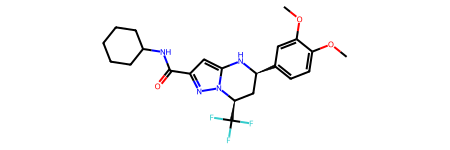

In [21]:
print(f"SMILES:\t{df.smiles[100]}\nlogP:\t{df.logP[100]}\nqed:\t{df.qed[100]}")
molecule = molecules_from_smile(df.smiles[100])
print("Molecule:")
molecule

In [42]:
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", \
                  "P", "Cl", "Br"]'

bond_mapping = {
    'SINGLE': 0,
    0: Chem.BondType.SINGLE,
    "DOUBLE": 1,
    1: Chem.BondType.DOUBLE,
    'TRIPLE': 2,
    0: Chem.BondType.TRIPLE,
    "AROMATIC": 3,
    1: Chem.BondType.AROMATIC,
}

SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)
# type(SMILE_CHARSET)

MAX_MOLSIZE = max(df['smiles'].str.len())
SMILE_to_index = dict((c,i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i,c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

# print(SMILE_to_index)
# print(index_to_SMILE)
# print(atom_mapping)

print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))

Max molecule size: 109
Character set Length: 11


In [ ]:
BATCH_SIZE = 32
EPOCH  = 10

VAE_LR = 5e-4
NUM_ATOMS = 120

ATOM_DIM = len(SMILE_CHARSET)
BOND_DIM = 4 + 1
LATENT_DIM = 435
